In [1]:
# load in packages
from itertools import combinations
from test_results import valid_results, test_results, score

import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk
import xgboost as xgb
from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
df=pd.read_excel("marketing_campaign.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
ID                     2240 non-null int64
Year_Birth             2240 non-null int64
Education              2240 non-null object
Marital_Status         2240 non-null object
Income                 2216 non-null float64
Kidhome                2240 non-null int64
Teenhome               2240 non-null int64
Dt_Customer            2240 non-null object
Recency                2240 non-null int64
MntWines               2240 non-null int64
MntFruits              2240 non-null int64
MntMeatProducts        2240 non-null int64
MntFishProducts        2240 non-null int64
MntSweetProducts       2240 non-null int64
MntGoldProds           2240 non-null int64
NumDealsPurchases      2240 non-null int64
NumWebPurchases        2240 non-null int64
NumCatalogPurchases    2240 non-null int64
NumStorePurchases      2240 non-null int64
NumWebVisitsMonth      2240 non-null int64
AcceptedCmp3           2240 

In [4]:
df['Income']=df['Income'].fillna(df['Income'].mean())

In [5]:
cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']

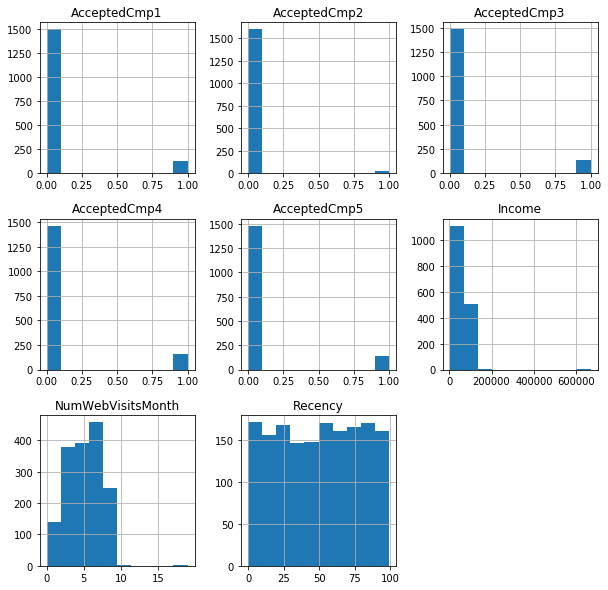

In [6]:
df[(df['NumDealsPurchases']!=0) & (df['NumCatalogPurchases']!=0)][cpgn].hist(figsize=(10,10));

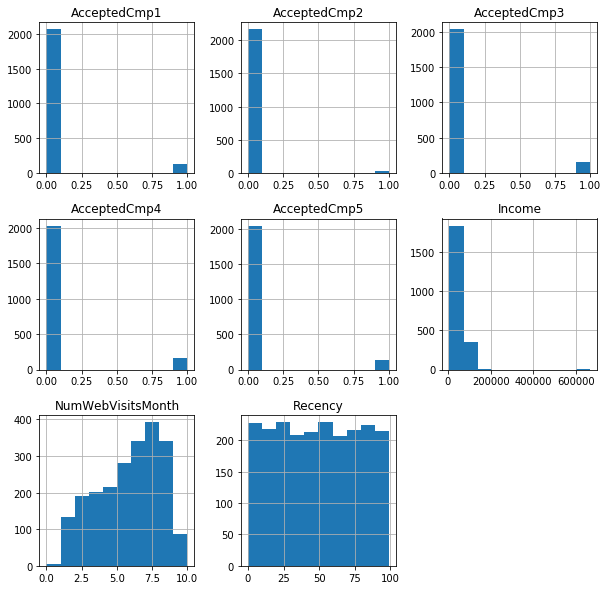

In [7]:
df[(df['NumDealsPurchases']!=0) & (df['NumStorePurchases']!=0)][cpgn].hist(figsize=(10,10));

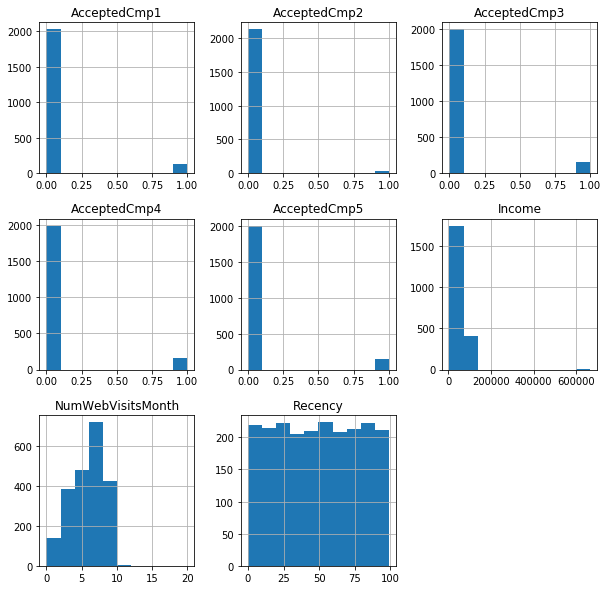

In [8]:
df[(df['NumDealsPurchases']!=0) & (df['NumWebPurchases']!=0)][cpgn].hist(figsize=(10,10));

From these graphs above, we can see that when given a discount on the products, customers have purchased more through web than catalogs and stors. Now we will create a binary column to assing people who have purchased goods through either stores, catalogs or web as '1' and others as '0'.

In [9]:
discount=[]
for i in range(len(df)):
    if ((df['NumDealsPurchases'][i]==0)):
        discount.append(0)
    else:
        discount.append(1)
     

In [10]:
df['Discount']=discount
#deleting unnecessary columns
df= df.drop(columns=['NumDealsPurchases','NumCatalogPurchases','NumStorePurchases','NumWebPurchases','Year_Birth','Education','Kidhome','Teenhome','Marital_Status','Dt_Customer'])


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 20 columns):
ID                   2240 non-null int64
Income               2240 non-null float64
Recency              2240 non-null int64
MntWines             2240 non-null int64
MntFruits            2240 non-null int64
MntMeatProducts      2240 non-null int64
MntFishProducts      2240 non-null int64
MntSweetProducts     2240 non-null int64
MntGoldProds         2240 non-null int64
NumWebVisitsMonth    2240 non-null int64
AcceptedCmp3         2240 non-null int64
AcceptedCmp4         2240 non-null int64
AcceptedCmp5         2240 non-null int64
AcceptedCmp1         2240 non-null int64
AcceptedCmp2         2240 non-null int64
Complain             2240 non-null int64
Z_CostContact        2240 non-null int64
Z_Revenue            2240 non-null int64
Response             2240 non-null int64
Discount             2240 non-null int64
dtypes: float64(1), int64(19)
memory usage: 350.1 KB


In [12]:
values, counts = np.unique(discount, return_counts=True)
values
counts

array([  46, 2194], dtype=int64)

In [13]:
train,test=train_test_split(df,test_size=0.2)

In [14]:
train.head()

,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Discount
1585,1626,35860.0,37,15,0,8,4,2,20,5,1,0,0,0,0,0,3,11,1,1
572,8181,38593.0,42,51,12,49,17,24,24,8,0,0,0,0,0,0,3,11,0,1
1633,10207,22775.0,40,5,1,8,0,0,1,8,0,0,0,0,0,0,3,11,0,1
478,8970,62010.0,93,371,22,39,6,0,92,5,0,0,0,0,0,0,3,11,0,1
2015,4102,37284.0,46,11,1,2,2,1,6,6,0,0,0,0,0,0,3,11,0,1


In [15]:
train.to_csv("train.csv")
test.to_csv("test.csv")

In [16]:
# testing baseline model, where we send promotions to everyone

def promotion_strategy(df):
    '''
                
    Ex:
    INPUT: df
    
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    
    
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    promotion = []
    
    num_test_points = test.shape[0]
    
    for i in range(num_test_points):
        promotion.append(1)
        
    promotion = np.array(promotion)
    
    return promotion

In [17]:
test_results(promotion_strategy)


Your Revenue generated with this strategy is -425.00.



-425

From this we can see that, if the company blindly sends out promotions to everyone, it would lead to a huge loss for the company. Therefore, we try building diiferent uplift models to find out which model gives the maximum profit to the company.

# Model 1: Traditional Uplift Model

In this approach, we will assign labels of 1 to those who received the promotions and made purchases, and labels of 0 to everyone else. In other words, we want the model to find the individuals who are likely to purchase only after they received a promotion. This is a simple model that surprisingly performed relatively well for this dataset, generating a revenue of $107, but a little less than the Four Quadrant approach.

In [18]:
# read data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [19]:
# generate labels
# only those who made a purchase after receiving a promotion will be assigned a label of 1, 
# while the other individuals will be given a label of 0

response_by_cust = []

for index, row in train_data.iterrows():
    if (row['Response'] == 1) and (row['Discount']==1):
        response_by_cust.append(1.0)
    else:
        response_by_cust.append(0.0)
        
train_data['response_by_cust'] = response_by_cust

In [20]:
train_data.head()

,Unnamed: 0,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Discount,response_by_cust
0,1585,1626,35860.0,37,15,0,8,4,2,20,...,0,0,0,0,0,3,11,1,1,1.0
1,572,8181,38593.0,42,51,12,49,17,24,24,...,0,0,0,0,0,3,11,0,1,0.0
2,1633,10207,22775.0,40,5,1,8,0,0,1,...,0,0,0,0,0,3,11,0,1,0.0
3,478,8970,62010.0,93,371,22,39,6,0,92,...,0,0,0,0,0,3,11,0,1,0.0
4,2015,4102,37284.0,46,11,1,2,2,1,6,...,0,0,0,0,0,3,11,0,1,0.0


In [21]:
train_data['response_by_cust'].value_counts()

0.0    1552
1.0     240
Name: response_by_cust, dtype: int64

In [22]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)


In [23]:

# generate features and labels
Y_train = train['response_by_cust']
X_train = train[cpgn]

Y_valid = valid['response_by_cust']
X_valid = valid[cpgn]

In [24]:
Y_train.value_counts()


0.0    1241
1.0     192
Name: response_by_cust, dtype: int64

In [25]:
# up sample only the train dataset with SMOTE
sm = SMOTE(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=cpgn)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [26]:
# Train an xgboost model
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          max_depth = 8,\
                          min_child_weight = 4,\
                          objective = 'binary:logistic',\
                          seed = 42,\
                          gamma = 0.1,\
                          silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
          eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.872477	validation_1-auc:0.666633
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.875928	validation_1-auc:0.669246
[2]	validation_0-auc:0.879677	validation_1-auc:0.668944
[3]	validation_0-auc:0.885008	validation_1-auc:0.679294
[4]	validation_0-auc:0.888252	validation_1-auc:0.684854
[5]	validation_0-auc:0.894767	validation_1-auc:0.681639
[6]	validation_0-auc:0.898921	validation_1-auc:0.681036
[7]	validation_0-auc:0.901358	validation_1-auc:0.681036
[8]	validation_0-auc:0.905216	validation_1-auc:0.682141
[9]	validation_0-auc:0.908253	validation_1-auc:0.679729
[10]	validation_0-auc:0.910196	validation_1-auc:0.680969
[11]	validation_0-auc:0.91072	validation_1-auc:0.680533
[12]	validation_0-auc:0.912732	validation_1-auc:0.678758
[13]	validation_0-auc:0.915557	validation_1-auc:0.678892
[14]	validation_0-auc:0.918548	validation_1-auc:0.679294

XGBClassifier(gamma=0.1, max_depth=8, min_child_weight=4, seed=42, silent=True)

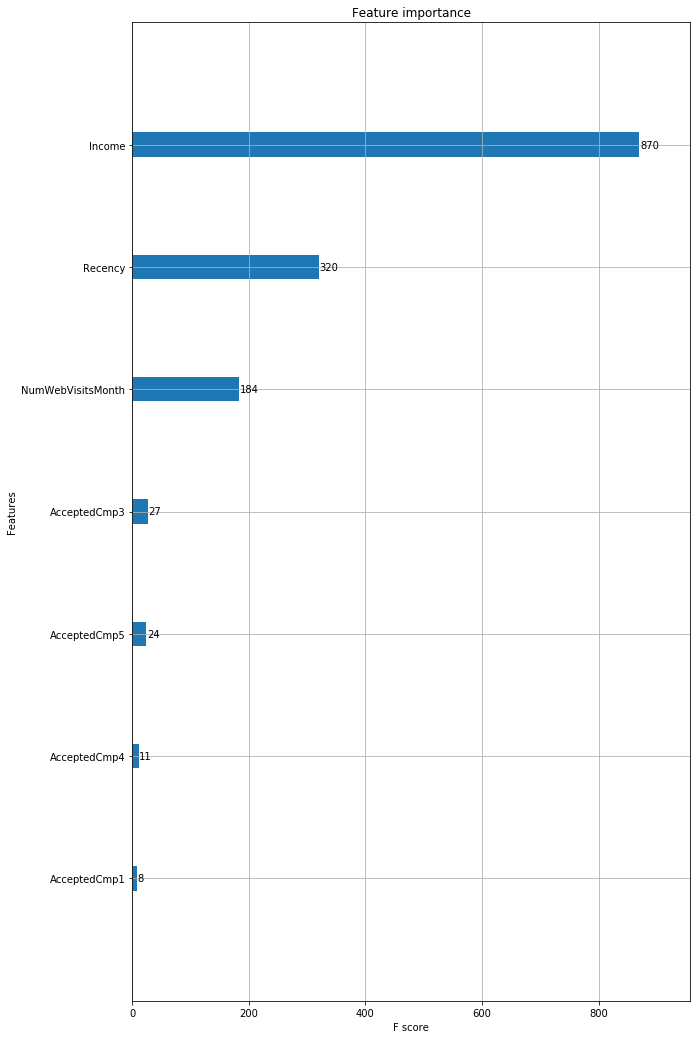

In [27]:

# check which features are important

from xgboost import plot_importance
from matplotlib import pyplot

fig, ax = pyplot.subplots(figsize=(10, 18));
xgb.plot_importance(model, ax=ax);

In [28]:

# confusion matrix
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix
cm(Y_valid, valid_pred)

array([[215,  96],
       [ 21,  27]], dtype=int64)

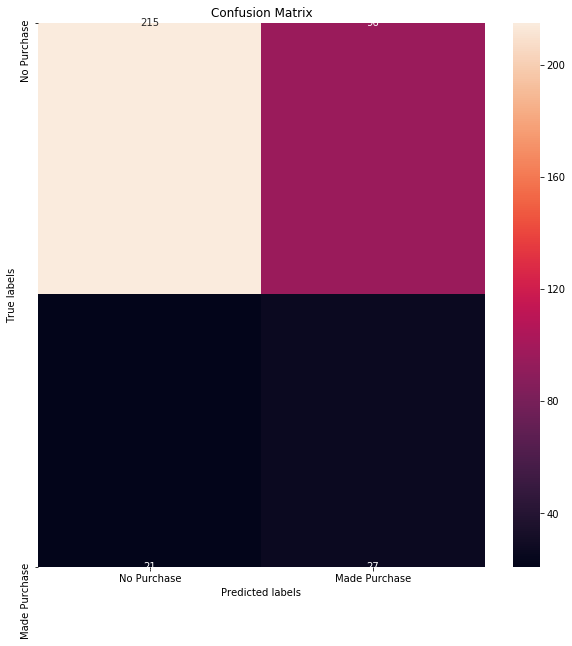

In [29]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [30]:
def promotion_strategy(df):
    '''
                
    Ex:
    INPUT: df
    
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    
    
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    preds = model.predict(test, ntree_limit=model.best_ntree_limit)

    promotion = []
    for pred in preds:
        if pred == 1:
            promotion.append(1)
        else:
            promotion.append(0)
    promotion = np.array(promotion)
    return promotion

In [31]:
# test irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is -58.00.



-58

In [32]:

# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)


Your Revenue generated with this strategy is 107.00.



107

# Model 2: Using two models approach

In this approach, we will train two models. One model will be trained on the treatment group (those who received the promotion) and we will refer to this model as the treatment model. Another model will be trained on the control group (those who did not received the promotion), and we will refer to this as the control model. The target of both models will be whether the individual made the purchase or not. The treatment model will predict the probability that individual will make a purchase if he or she received the promotion, while the control model will predict the probability that individual will make a purchase if he or she did not receive the promotion. Ideally the difference in the probabilities, which we will call the lift:

$$ Lift = P(purchase | treatment) - P(purchase | control) $$

will tell us the probability that sending a promotion to an individual will increase his or her willingness to make a purhcase vs not sending a promotion. We can then send promotions to individuals with lift values higher than a pre-defined cutoff percentile. For example, we can send promotions to individuals in the top 3 deciles.

This model performed quite well than the third model, but still predicted that the company would face a little loss if they followed this strategy. 

In [33]:

# read data
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [34]:
# split data into train and valid
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

In [35]:
cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']

# Generate validation data
# one for control group, another for treatment group
valid_control = valid[valid['Discount']==0]
Y_valid_control = valid_control['Response']
X_valid_control = valid_control[cpgn]

valid_exper = valid[valid['Discount']==1]
Y_valid_exper = valid_exper['Response']
X_valid_exper = valid_exper[cpgn]

In [36]:
# generate training data
train_control = train[train['Discount']==0]
Y_train_control = train_control['Response']
X_train_control = train_control[cpgn]

train_exper = train[train['Discount']==1]
Y_train_exper = train_exper['Response']
X_train_exper = train_exper[cpgn]

In [37]:
Y_train_exper.value_counts()


0    1210
1     192
Name: Response, dtype: int64

In [38]:
# up-sample training data with SMOTE
sm = SMOTE(random_state=42)

# up-sample control group
X_train_control_upsamp, Y_train_control_upsamp = sm.fit_sample(X_train_control, Y_train_control)
X_train_control_upsamp = pd.DataFrame(X_train_control_upsamp, columns=cpgn)
Y_train_control_upsamp = pd.Series(Y_train_control_upsamp)

# up-sample treatment group
X_train_exper_upsamp, Y_train_exper_upsamp = sm.fit_sample(X_train_exper, Y_train_exper)    
X_train_exper_upsamp = pd.DataFrame(X_train_exper_upsamp, columns=cpgn)
Y_train_exper_upsamp = pd.Series(Y_train_exper_upsamp)

In [39]:

# train control model
eval_set = [(X_train_control_upsamp, Y_train_control_upsamp), (X_valid_control, Y_valid_control)]
model_control = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 1,\
                                  #colsample_bytree = 0.1,\
                                  silent = True)
model_control.fit(X_train_control_upsamp, Y_train_control_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:0.5	validation_1-auc:0.5
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.5	validation_1-auc:0.5
[2]	validation_0-auc:0.5	validation_1-auc:0.5
[3]	validation_0-auc:0.5	validation_1-auc:0.5
[4]	validation_0-auc:0.5	validation_1-auc:0.5
[5]	validation_0-auc:0.5	validation_1-auc:0.5
[6]	validation_0-auc:0.5	validation_1-auc:0.5
[7]	validation_0-auc:0.5	validation_1-auc:0.5
[8]	validation_0-auc:0.5	validation_1-auc:0.5
[9]	validation_0-auc:0.5	validation_1-auc:0.5
[10]	validation_0-auc:0.5	validation_1-auc:0.5
[11]	validation_0-auc:0.5	validation_1-auc:0.5
[12]	validation_0-auc:0.5	validation_1-auc:0.5
[13]	validation_0-auc:0.5	validation_1-auc:0.5
[14]	validation_0-auc:0.5	validation_1-auc:0.5
[15]	validation_0-auc:0.5	validation_1-auc:0.5
[16]	validation_0-auc:0.5	validation_1-auc:0.5
[17]	validation_0-auc:0.5	validation_1-auc:0.5
[18]	va

XGBClassifier(gamma=1, max_depth=7, min_child_weight=5, seed=42, silent=True)

In [40]:
# train treatment model
eval_set = [(X_train_exper_upsamp, Y_train_exper_upsamp), (X_valid_exper, Y_valid_exper)]
model_exper = xgb.XGBClassifier(learning_rate = 0.1,\
                                max_depth = 7,\
                                min_child_weight = 5,\
                                objective = 'binary:logistic',\
                                seed = 42,\
                                gamma = 1,\
                                #colsample_bytree = 0.1,\
                                silent = True)
model_exper.fit(X_train_exper_upsamp, Y_train_exper_upsamp, eval_set=eval_set,\
                eval_metric="auc", verbose=True, early_stopping_rounds=30)


[0]	validation_0-auc:0.835565	validation_1-auc:0.613707
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:0.849432	validation_1-auc:0.61782
[2]	validation_0-auc:0.867742	validation_1-auc:0.626854
[3]	validation_0-auc:0.873202	validation_1-auc:0.641619
[4]	validation_0-auc:0.877893	validation_1-auc:0.645463
[5]	validation_0-auc:0.886251	validation_1-auc:0.65652
[6]	validation_0-auc:0.887488	validation_1-auc:0.656183
[7]	validation_0-auc:0.889623	validation_1-auc:0.662352
[8]	validation_0-auc:0.892983	validation_1-auc:0.664003
[9]	validation_0-auc:0.89576	validation_1-auc:0.664138
[10]	validation_0-auc:0.896652	validation_1-auc:0.660498
[11]	validation_0-auc:0.898935	validation_1-auc:0.662149
[12]	validation_0-auc:0.901218	validation_1-auc:0.665082
[13]	validation_0-auc:0.901228	validation_1-auc:0.665217
[14]	validation_0-auc:0.901978	validation_1-auc:0.666161
[

XGBClassifier(gamma=1, max_depth=7, min_child_weight=5, seed=42, silent=True)

In [41]:
# make predictions on the validation data sets for both models
control_valid_pred = model_control.predict(X_valid_control, ntree_limit=model_control.best_ntree_limit)
exper_valid_pred = model_exper.predict(X_valid_exper, ntree_limit=model_exper.best_ntree_limit)

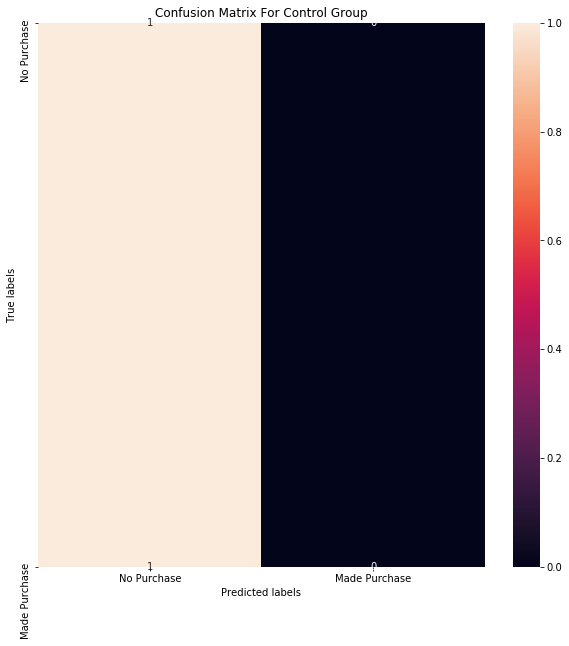

In [42]:

# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_control, control_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Control Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

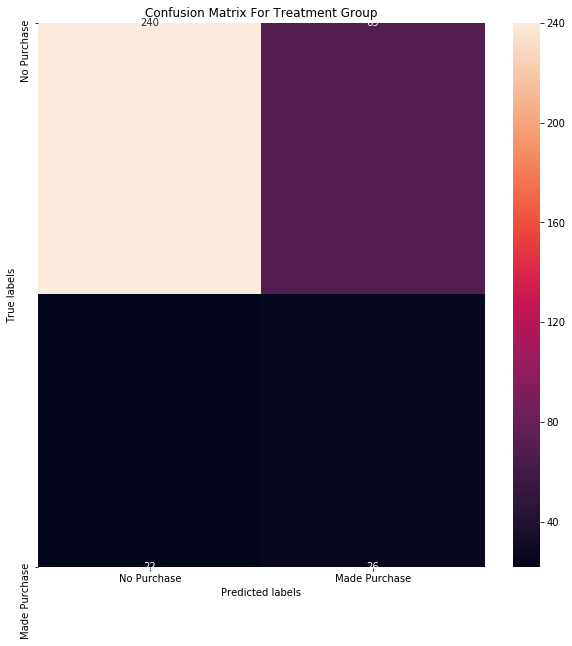

In [43]:
# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid_exper, exper_valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix For Treatment Group'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [44]:

def promotion_strategy(df):
    '''
                
    Ex:
    INPUT: df
    
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    
    
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred_probs_contol = model_control.predict_proba(test, ntree_limit=model_control.best_ntree_limit)

    pred_probs_exper = model_exper.predict_proba(test, ntree_limit=model_exper.best_ntree_limit)

    # get difference in probabilities between experimental and cpntrol model for purchase = 1 label
    lift = pred_probs_exper[:,1] - pred_probs_contol[:,1]
    
    promotion = []
    
    # Only send promotions to top 3 percentile of probabilities
    cutoff_lift = np.percentile(lift, 97)
    
    for prob in lift:
        if prob > 0:
            if prob > cutoff_lift:
                promotion.append(1)
        else:
            promotion.append(0)

    promotion = np.array(promotion)
    
    return promotion

In [45]:

# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is -22.00.



-22

In [46]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)


Your Revenue generated with this strategy is -20.00.



-20

# Model 3: Single Model with Treatment Indicator Variable


In this approach, a single model is used to model the data. Unlike the approach used in the first model, this approach adds an additional indicator variable to track if an individual is in a treatment or control group during training. Any individuals who made purchases will be given a label of 1, irregradless of whether he or she is in the control or treatment group.

To predict whether a new individual in a test set is likely to make a purhcase only after receiving a promotion, we can first calculate the probability that the individual will make a purchase if he or she is in the treatment group by setting the treatment indicator as 1. Next, we calculate the probability that the individual will make a purchase if he or she is in the control group by setting the treatment indicator as 0. The difference in the two probabilities will be the lift value, aka, how positively influenced the individual is as a result of the treatment (receiving promotion):

$$Lift = P(purchase | I_{treat} = 1) - P(purchase |  I_{treat} = 0)$$

We can opt to send promotions to individuals with prostive lift values.

This model didnt perform well compared to the others. The revenue predicted shows a huge loss for the company.

In [47]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [48]:
# encode Promotion as 0 or 1 indicator variable
train_data['treatment'] = np.where(train_data['Discount'] == 1, 1, 0)
train_data.head()

,Unnamed: 0,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Discount,treatment
0,1585,1626,35860.0,37,15,0,8,4,2,20,...,0,0,0,0,0,3,11,1,1,1
1,572,8181,38593.0,42,51,12,49,17,24,24,...,0,0,0,0,0,3,11,0,1,1
2,1633,10207,22775.0,40,5,1,8,0,0,1,...,0,0,0,0,0,3,11,0,1,1
3,478,8970,62010.0,93,371,22,39,6,0,92,...,0,0,0,0,0,3,11,0,1,1
4,2015,4102,37284.0,46,11,1,2,2,1,6,...,0,0,0,0,0,3,11,0,1,1


In [49]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth','treatment']

Y_train = train['Discount']
X_train = train[cpgn]

Y_valid = valid['Discount']
X_valid = valid[cpgn]

In [50]:

# up sample with SMOTE
sm = SMOTE(random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=cpgn)

Y_train_upsamp = pd.Series(Y_train_upsamp)

In [51]:
eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                                  max_depth = 7,\
                                  min_child_weight = 5,\
                                  objective = 'binary:logistic',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="auc", verbose=True, early_stopping_rounds=30)

[0]	validation_0-auc:1	validation_1-auc:1
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 30 rounds.
[1]	validation_0-auc:1	validation_1-auc:1
[2]	validation_0-auc:1	validation_1-auc:1
[3]	validation_0-auc:1	validation_1-auc:1
[4]	validation_0-auc:1	validation_1-auc:1
[5]	validation_0-auc:1	validation_1-auc:1
[6]	validation_0-auc:1	validation_1-auc:1
[7]	validation_0-auc:1	validation_1-auc:1
[8]	validation_0-auc:1	validation_1-auc:1
[9]	validation_0-auc:1	validation_1-auc:1
[10]	validation_0-auc:1	validation_1-auc:1
[11]	validation_0-auc:1	validation_1-auc:1
[12]	validation_0-auc:1	validation_1-auc:1
[13]	validation_0-auc:1	validation_1-auc:1
[14]	validation_0-auc:1	validation_1-auc:1
[15]	validation_0-auc:1	validation_1-auc:1
[16]	validation_0-auc:1	validation_1-auc:1
[17]	validation_0-auc:1	validation_1-auc:1
[18]	validation_0-auc:1	validation_1-auc:1
[19]	validation_0-auc:1	validation_1

XGBClassifier(gamma=0.1, max_depth=7, min_child_weight=5, seed=42, silent=True)

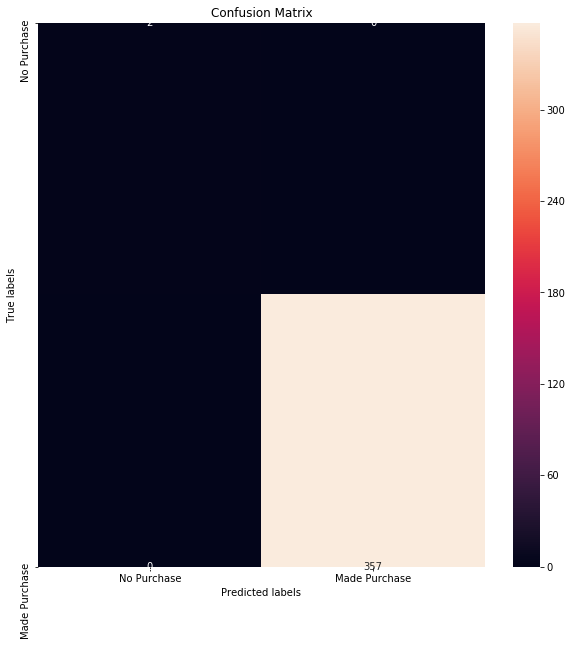

In [52]:

# confusion marix for thge validation set
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['No Purchase', 'Made Purchase']); 
ax.yaxis.set_ticklabels(['No Purchase', 'Made Purchase']);

In [53]:
def promotion_strategy(df):
    '''
                
    Ex:
    INPUT: df
    
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    
    
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    # Fit a model with treatment = 1 for all data points
    test['treatment'] = 1.0
    preds_treat = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    # Fit a model with treatment = 0 for all data points
    test['treatment'] = 0.0
    preds_cont = model.predict_proba(test, ntree_limit=model.best_ntree_limit)
    
    lift = preds_treat[:,1] - preds_cont[:,1]
    
    promotion = []
    
    for prob in lift:
        if prob > 0:
            promotion.append(1)
        else:
            promotion.append(0)

    promotion = np.array(promotion)
    
    return promotion

In [54]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is -532.00.



C:\Users\vignesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vignesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-532

In [55]:
test_results(promotion_strategy)


Your Revenue generated with this strategy is -425.00.



C:\Users\vignesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\vignesh\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


-425

# Model 4: Four Quadrants Approach


This model helps to predict an individual's probability of being in any of the 4 groups: TR, CR, TN, CN.

TR: Treatment and Responded. Basically received promotion and made a purchase CR: Control and Responded. Did not receive a promotion but made a purchase TN: Treatment and No Response. Received promotion but made no purchase CN: Control and No Response. Did not receive a promotion and made no purchase.

If an individual's TR probability is the highest among the four groups, it is likely that we will benefit by sending the individual a promotion to induce him or her to make a purchase.In other words, if for an individual:

$$ max[P(TR), P(CR), P(TN), P(CN)] = P(TR)$$
we should send a promotion.

This model has predicted that the company would get the maximum profit through this model. It predicted that the company would generate a profit of $111.

In [56]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [57]:
target = []
for index, row in train_data.iterrows():
    if (row['Discount'] == 1) & (row['Response'] == 1):
        # TR group
        target.append(0)
    elif (row['Discount'] == 0) & (row['Response'] == 1):
        # CR group
        target.append(1)
    elif (row['Discount'] == 0) & (row['Response'] == 0):
        # TN group
        target.append(2)
    else: #CN group
        target.append(3)

train_data['target'] = target
train_data.head()

,Unnamed: 0,ID,Income,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response,Discount,target
0,1585,1626,35860.0,37,15,0,8,4,2,20,...,0,0,0,0,0,3,11,1,1,0
1,572,8181,38593.0,42,51,12,49,17,24,24,...,0,0,0,0,0,3,11,0,1,3
2,1633,10207,22775.0,40,5,1,8,0,0,1,...,0,0,0,0,0,3,11,0,1,3
3,478,8970,62010.0,93,371,22,39,6,0,92,...,0,0,0,0,0,3,11,0,1,3
4,2015,4102,37284.0,46,11,1,2,2,1,6,...,0,0,0,0,0,3,11,0,1,3


In [58]:
train, valid = sk.model_selection.train_test_split(train_data, test_size=0.2,random_state=42)

cpgn=['AcceptedCmp1','AcceptedCmp2','AcceptedCmp3','AcceptedCmp4','AcceptedCmp5','Income','Recency','NumWebVisitsMonth']

Y_train = train['target']
X_train = train[cpgn]

Y_valid = valid['target']
X_valid = valid[cpgn]

In [59]:
Y_train.value_counts()

3    1210
0     192
2      18
1      13
Name: target, dtype: int64

In [60]:
# up sample with SMOTE
sm = SMOTE({0:33444, 1:33444, 2:33444, 3:33444}, random_state=42)
X_train_upsamp, Y_train_upsamp = sm.fit_sample(X_train, Y_train)
    
X_train_upsamp = pd.DataFrame(X_train_upsamp, columns=cpgn)

Y_train_upsamp = pd.Series(Y_train_upsamp)
Y_train_upsamp.value_counts()

C:\Users\vignesh\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:324: UserWarning: After over-sampling, the number of samples (33444) in class 0 will be larger than the number of samples in the majority class (class #3 -> 1210)
  n_samples_majority,
C:\Users\vignesh\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:324: UserWarning: After over-sampling, the number of samples (33444) in class 1 will be larger than the number of samples in the majority class (class #3 -> 1210)
  n_samples_majority,
C:\Users\vignesh\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:324: UserWarning: After over-sampling, the number of samples (33444) in class 2 will be larger than the number of samples in the majority class (class #3 -> 1210)
  n_samples_majority,
C:\Users\vignesh\Anaconda3\lib\site-packages\imblearn\utils\_validation.py:324: UserWarning: After over-sampling, the number of samples (33444) in class 3 will be larger than the number of samples in the majority class (

3    33444
2    33444
1    33444
0    33444
Name: target, dtype: int64

In [61]:
X_train_upsamp.head()


,AcceptedCmp1,AcceptedCmp2,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,Income,Recency,NumWebVisitsMonth
0,0,0,0,0,1,77382.000000,36,1
1,0,0,0,0,0,52247.251354,83,6
2,0,0,0,1,0,64100.000000,93,7
3,0,0,0,0,0,41275.000000,33,5
4,0,0,0,0,0,53761.000000,7,5


In [62]:

eval_set = [(X_train_upsamp, Y_train_upsamp), (X_valid, Y_valid)]
model = xgb.XGBClassifier(learning_rate = 0.1,\
                          
                                  max_depth = 8,\
                                  min_child_weight = 5,\
                                  objective = 'multi:softmax',\
                                  seed = 42,\
                                  gamma = 0.1,\
                                  silent = True)
model.fit(X_train_upsamp, Y_train_upsamp, eval_set=eval_set,\
                    eval_metric="mlogloss", verbose=True, early_stopping_rounds=30)

[0]	validation_0-mlogloss:1.24487	validation_1-mlogloss:1.3091
Multiple eval metrics have been passed: 'validation_1-mlogloss' will be used for early stopping.

Will train until validation_1-mlogloss hasn't improved in 30 rounds.
[1]	validation_0-mlogloss:1.12791	validation_1-mlogloss:1.24842
[2]	validation_0-mlogloss:1.03067	validation_1-mlogloss:1.19901
[3]	validation_0-mlogloss:0.948042	validation_1-mlogloss:1.15228
[4]	validation_0-mlogloss:0.877357	validation_1-mlogloss:1.1147
[5]	validation_0-mlogloss:0.81516	validation_1-mlogloss:1.08279
[6]	validation_0-mlogloss:0.760437	validation_1-mlogloss:1.05514
[7]	validation_0-mlogloss:0.711592	validation_1-mlogloss:1.03084
[8]	validation_0-mlogloss:0.668377	validation_1-mlogloss:1.01097
[9]	validation_0-mlogloss:0.629756	validation_1-mlogloss:0.992611
[10]	validation_0-mlogloss:0.595305	validation_1-mlogloss:0.976741
[11]	validation_0-mlogloss:0.56377	validation_1-mlogloss:0.963329
[12]	validation_0-mlogloss:0.536116	validation_1-mloglo

XGBClassifier(gamma=0.1, max_depth=8, min_child_weight=5,
              objective='multi:softprob', seed=42, silent=True)

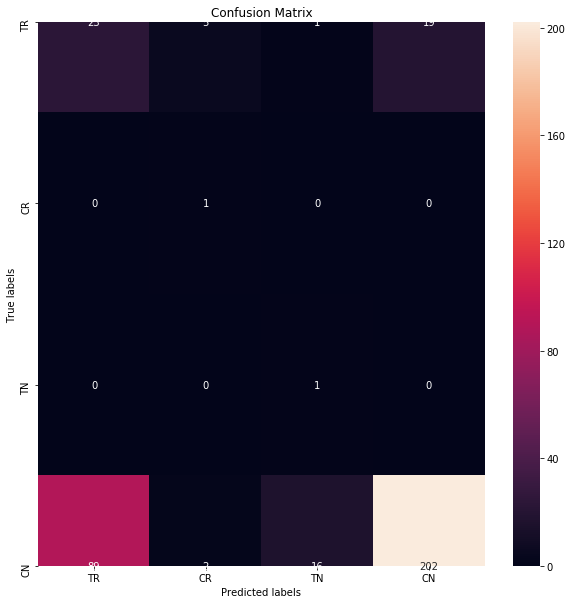

In [63]:

# confusion marix for the validation set
# Note:
# TR: treatment and respond group (received promotion and made purchase)
# CR: control and respond group (did not receive promotion but made purchase)
# TN: treatment and no respond group (received promotion but did not made purchase)
# CR: control and no respond group (did not receive promotion and made no purchase)
valid_pred = model.predict(X_valid, ntree_limit=model.best_ntree_limit)
cm = sk.metrics.confusion_matrix(Y_valid, valid_pred)

fig, ax= plt.subplots(figsize=(10,10))
sb.heatmap(cm, annot=True, fmt='g', ax = ax); #annot=True to annotate cells

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']); 
ax.yaxis.set_ticklabels(['TR', 'CR', 'TN', 'CN']);

In [66]:
def promotion_strategy(df):
    '''
                
    Ex:
    INPUT: df
    
    AcceptedCmp1->AcceptedCmp2->AcceptedCmp3->AcceptedCmp4->AcceptedCmp5->Income->Recency->NumWebVisitsMonth
    
    
    OUTPUT: promotion
    
    array([1, 1, 0])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    test = df
    
    pred = model.predict(test, ntree_limit=model.best_ntree_limit)
    
    promotion = []
    
    for pred in pred:
        if pred == 0:
            promotion.append(1)
        else:
            promotion.append(0)
    
    promotion = np.array(promotion)
    
    return promotion

In [67]:
# find out irr and nlr on our validation set
valid_results(promotion_strategy, valid)


Your Revenue generated with this strategy is -83.00.



-83

In [68]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)


Your Revenue generated with this strategy is 111.00.



111